In [1]:
# light gbm feature selection
# https://www.kaggle.com/harangdev/feature-selection

# light gbm parameters 설명
# https://greatjoy.tistory.com/72

# Permutation Importance
# https://eat-toast.tistory.com/10

# shap
# https://data-newbie.tistory.com/254

In [2]:
import numpy as np
import pandas as pd

from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy
import shap
import eli5
from eli5.sklearn import PermutationImportance

import matplotlib.pyplot as plt

import warnings
import gc
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [3]:
train = pd.read_csv('../data/train.csv', index_col='id')
test = pd.read_csv('../data/test.csv', index_col='id')
submission = pd.read_csv('../data/sample_submission.csv', index_col='id')

In [4]:
def rmse_expm1(pred, true):
    return -np.sqrt(np.mean((np.expm1(pred)-np.expm1(true))**2))

def evaluate(x_data, y_data):
    model = LGBMRegressor(objective='regression', num_iterations=10**5)
    x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, random_state=0)
    model.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=100, verbose=False)
    val_pred = model.predict(x_val)
    score = rmse_expm1(val_pred, y_val)
    return score

def rfe(x_data, y_data, method, ratio=0.9, min_feats=40):
    feats = x_data.columns.tolist()
    archive = pd.DataFrame(columns=['model', 'n_feats', 'feats', 'score'])
    while True:
        model = LGBMRegressor(objective='regression', num_iterations=10**5)
        x_train, x_val, y_train, y_val = train_test_split(x_data[feats], y_data, random_state=0)
        model.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=100, verbose=False)
        val_pred = model.predict(x_val)
        score = rmse_expm1(val_pred, y_val)
        n_feats = len(feats)
        print(n_feats, score)
        archive = archive.append({'model': model, 'n_feats': n_feats, 'feats': feats, 'score': score}, ignore_index=True)
        if method == 'basic':
            feat_imp = pd.Series(model.feature_importances_, index=feats).sort_values(ascending=False)
        elif method == 'perm':
            perm = PermutationImportance(model, random_state=0).fit(x_val, y_val)
            feat_imp = pd.Series(perm.feature_importances_, index=feats).sort_values(ascending=False)
        elif method == 'shap':
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(x_data[feats])
            feat_imp = pd.Series(np.abs(shap_values).mean(axis=0), index=feats).sort_values(ascending=False)
        next_n_feats = int(n_feats * ratio)
        if next_n_feats < min_feats:
            break
        else:
            feats = feat_imp.iloc[:next_n_feats].index.tolist()
    return archive

In [5]:
features = ['X00', 'X01', 'X02', 'X03', 'X05', 'X06', 'X07', 'X08', 'X09', 'X10', 'X11', 'X12', 'X13', 'X15', 'X17', 'X18', 'X20', 'X21', 'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X37', 'X38', 'X39']

In [6]:
model = LGBMRegressor(objective='regression', num_iterations=10**3)

trainIsNull = train[train['Y18'].isnull()]


x_data = trainIsNull[features]
y_data = trainIsNull['Y00']
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, random_state=0)

model.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=100, verbose=False)

val_pred = model.predict(x_val)
score = rmse_expm1(val_pred, y_val)
score

-2025780998808.443

In [8]:
%%time
basic_archive = rfe(x_data, y_data, 'basic', min_feats=10)

35-2023343621304.314
31-1820913717975.6824
27-2035978110067.9436
24-1937556797434.4358
21-2312505189226.158
18-2356068133088.2754
16-2467272993138.3066
14-2481352387854.227
12-2641194346203.5317
10-2539945920809.897
Wall time: 32 s


In [7]:
# model.feature_importances_ 를 통해 변수 별 중요도를 파악할 수 있음
# 3개씩 중요도가 높은 변수들을 추가시킴
# 31개 에서 가장 낮은 수치가 나옴


feat_imp = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
for i in range(10, 43, 3):
    print(i, evaluate(trainIsNull[feat_imp.iloc[:i].index], trainIsNull['Y00']))

10-2638042635175.884
13-2493064366076.8774
16-2559430094329.0605
19-2541506940560.825
22-2076036970518.7314
25-1973379730237.5193
28-1954836221963.4507
31-1820913717975.6824
34-1864241341878.6711
37-2082227883257.1787
40-2082227883257.1787


In [8]:
model.feature_importances_

array([ 944,  509, 1263, 1176,  424,  465, 1316,  461,  551,   63,  793,
       1249, 1749, 1568, 1347, 1096, 1160,   48,  283,  340,  702,  959,
       1116,  484, 1038,  314, 1178, 1139,  898,  313,  723, 1721, 1091,
       1266,   43])

In [19]:
feat_imp

X13    1749
X35    1721
X15    1568
X17    1347
X07    1316
X38    1266
X02    1263
X12    1249
X30    1178
X03    1176
X20    1160
X31    1139
X26    1116
X18    1096
X37    1091
X28    1038
X25     959
X00     944
X32     898
X11     793
X34     723
X24     702
X09     551
X01     509
X27     484
X06     465
X08     461
X05     424
X23     340
X29     314
X33     313
X22     283
X10      63
X21      48
X39      43
dtype: int32

In [10]:
%%time
perm_archive = rfe(x_data, y_data, 'perm', min_feats=10)

35-2023343621304.314
31-1805902149833.1465
27-1968072134911.1123
24-1837880635069.4966
21-1557748002833.0085
18-1668212270830.0427
16-1445899298646.167
14-1510780844598.6753
12-1585178596263.52
10-1661447556508.8752
Wall time: 1min 7s


In [11]:
perm = PermutationImportance(model, random_state=0).fit(x_val, y_val)
perm_feat_imp = pd.Series(perm.feature_importances_, index=features).sort_values(ascending=False)
eli5.show_weights(perm)

Weight,Feature
1.0906 ± 0.0400,x6
0.0716 ± 0.0048,x24
0.0366 ± 0.0046,x30
0.0133 ± 0.0018,x10
0.0023 ± 0.0003,x28
0.0020 ± 0.0001,x27
0.0015 ± 0.0001,x11
0.0014 ± 0.0004,x16
0.0009 ± 0.0001,x33
0.0006 ± 0.0001,x26


In [18]:
perm_feat_imp

X07    1.090575
X28    0.071614
X34    0.036584
X11    0.013307
X32    0.002292
X31    0.002020
X12    0.001497
X20    0.001352
X38    0.000862
X30    0.000571
X37    0.000510
X05    0.000401
X39    0.000367
X08    0.000365
X00    0.000353
X15    0.000273
X06    0.000217
X09    0.000193
X27    0.000163
X01    0.000142
X02    0.000124
X35    0.000123
X18    0.000121
X26    0.000099
X22    0.000097
X29    0.000074
X23    0.000073
X13    0.000073
X21    0.000066
X24    0.000061
X33    0.000060
X10    0.000059
X17    0.000058
X25    0.000020
X03    0.000011
dtype: float64

In [12]:
for i in range(10, 43, 3):
    print(i, evaluate(trainIsNull[perm_feat_imp.iloc[:i].index], trainIsNull['Y00']))

10-1335604155324.9072
13-1661915368831.5735
16-1679302279478.9067
19-1509487773667.6953
22-1745246496780.2012
25-2138369178672.8608
28-1935410542201.0923
31-1805902149833.1465
34-1997759039656.438
37-2055417613221.5627
40-2055417613221.5627


In [13]:
%%time
shap_archive = rfe(x_data, y_data, 'shap', min_feats=10)

35-2023343621304.314
31-2023653166710.04
27-2008106238181.814
24-1898729618997.0923
21-1720545318487.713
18-1595369424243.479
16-1788066162715.756
14-1655249250808.8083
12-1644684630962.4287
10-1734956013065.3875
Wall time: 2min 8s


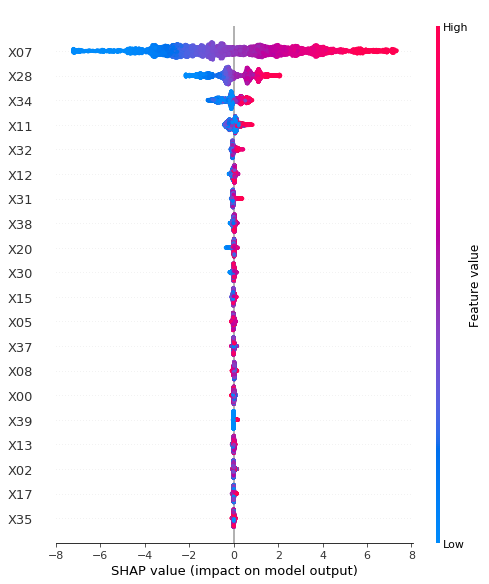

In [14]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_data)
shap_feat_imp = pd.Series(np.abs(shap_values).mean(axis=0), index=features).sort_values(ascending=False)
shap.summary_plot(shap_values, x_data)

In [15]:
for i in range(10, 43, 3):
    print(i, evaluate(trainIsNull[shap_feat_imp.iloc[:i].index], trainIsNull['Y00']))

10-1335604155324.9072
13-1524498465856.1118
16-1679302279478.9067
19-1512134934923.3174
22-1624522067315.3635
25-1992410475409.9692
28-1806952573105.579
31-2023653166710.04
34-1901479212454.087
37-2055516828964.5088
40-2055516828964.5088


In [16]:
shap_feat_imp

X07    2.600508
X28    0.761179
X34    0.385532
X11    0.188108
X32    0.069999
X12    0.044804
X31    0.044577
X38    0.034448
X20    0.032414
X30    0.027180
X15    0.026280
X05    0.024077
X37    0.018819
X08    0.018136
X00    0.017367
X39    0.017316
X13    0.016791
X02    0.016586
X17    0.015440
X35    0.015015
X09    0.013193
X23    0.013082
X06    0.012385
X03    0.012304
X18    0.011863
X26    0.011698
X27    0.011347
X01    0.011088
X22    0.010476
X25    0.009520
X24    0.008730
X29    0.006961
X33    0.006633
X10    0.005696
X21    0.004376
dtype: float64